# Waze - Regression Analysis

This work involves the development and experimental evaluation of a logistic regression model, based on the findinds of the exploratory data analysis (EDA). More specifically, we want to build a regression model to predict user churn based on a variety of variables. Logistic regression is useful for estimating the probability of a certain outcome, especially when multiple variables can influence the outcome. This capability makes it a powerful tool for performing comprehensive and flexible analysis.

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [46]:
# reading the data
df = pd.read_csv("waze_dataset.csv")
df = df.dropna(subset=["label"])
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14299 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14299 non-null  int64  
 3   drives                   14299 non-null  int64  
 4   total_sessions           14299 non-null  float64
 5   n_days_after_onboarding  14299 non-null  int64  
 6   total_navigations_fav1   14299 non-null  int64  
 7   total_navigations_fav2   14299 non-null  int64  
 8   driven_km_drives         14299 non-null  float64
 9   duration_minutes_drives  14299 non-null  float64
 10  activity_days            14299 non-null  int64  
 11  driving_days             14299 non-null  int64  
 12  device                   14299 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [48]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Extreme data values and outliers can greatly influence logistic regression models. A plan should be devised to handle these outliers by either removing rows, replacing values with averages or eliminating data points beyond three standard deviations. Missing values in the label column and other features are also addressed.

In [49]:
# dropping column for the ID
df = df.drop("ID", axis=1)

# checking class balance for the label
df["label"].value_counts(normalize=True)

,proportion
label,
retained,0.822645
churned,0.177355


In [50]:
# creating new column for the distance per driving day
df["km_per_driving_day"] = df["driven_km_drives"] / df["driving_days"]
df.loc[df["km_per_driving_day"]==np.inf, "km_per_driving_day"] = 0

# creating new column for the driver
df["professional_driver"] = np.where((df["drives"] >= 60) & (df["driving_days"] >= 15), 1, 0)

# checking balance of professional and non-professional driver
print(df["professional_driver"].value_counts())

# checking in-class churn rate
df.groupby(["professional_driver"])["label"].value_counts(normalize=True)

professional_driver
0    11811
1     2488
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

In [51]:
# imputing outliers
columns_to_clean = ["sessions",
                    "drives",
                    "total_sessions",
                    "total_navigations_fav1",
                    "total_navigations_fav2",
                    "driven_km_drives",
                    "duration_minutes_drives"]
for column in columns_to_clean:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [52]:
# creating new binary column for the label
df["label2"] = np.where(df["label"]=="churned", 1, 0)

# creating new binary column for the device
df["device2"] = np.where(df["device"]=="Android", 0, 1)

In [53]:
# creating correlation matrix (pairwise correlation) using pearson correlation coefficient
df.corr(method="pearson", numeric_only=True)

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911,0.012704
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865,0.011684
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568,0.012138
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263,-0.011299
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322,-0.001316
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032,-0.000275
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767,-0.002091
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407,-0.007709
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851,-0.010221
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259,-0.003859


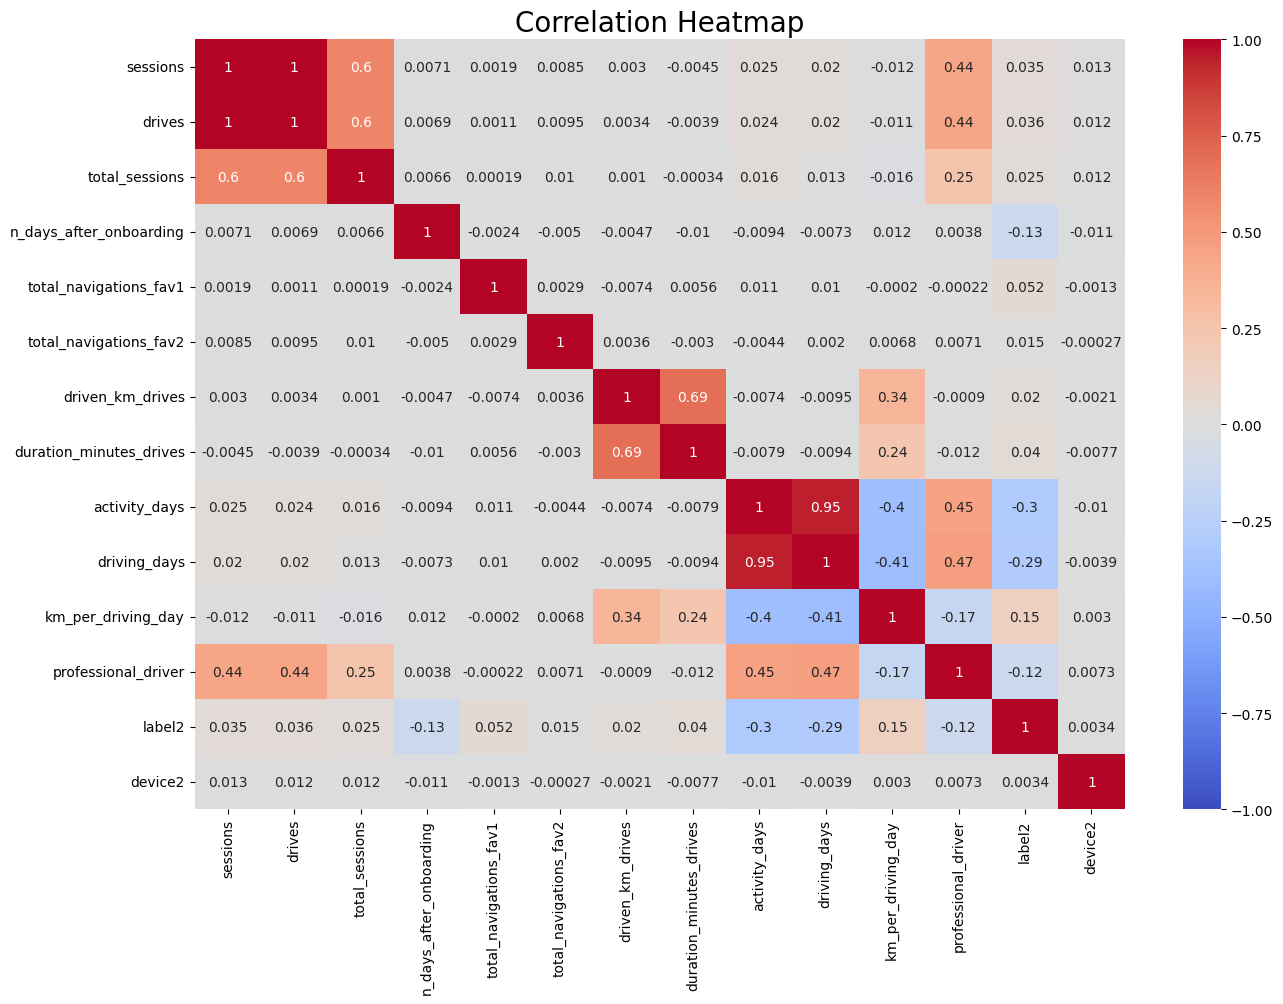

In [54]:
# creating correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method="pearson", numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

New variables, such as `km_per_driving_day` and `professional_driver`, were created to better capture the dynamics within the data. Additionally, columns with high multicollinearity were excluded from the model. The fundamental model assumptions include the independent observations, the management of extreme outliers, the low multicollinearity among predictors and the linear relationship between predictors and the logit of the outcome.

In [55]:
# isolating the features (X) and the target variable (y)
y = df["label2"]
X = df.drop(columns = ["label", "label2", "device", "sessions", "driving_days"])

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
# fitting the model to the training data
log_clf = LogisticRegression(random_state=0, max_iter=800)
log_clf.fit(X_train, y_train)

In [57]:
# creating new column for the logit data
training_probabilities = log_clf.predict_proba(X_train)
logit_data = X_train.copy()
logit_data["logit"] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

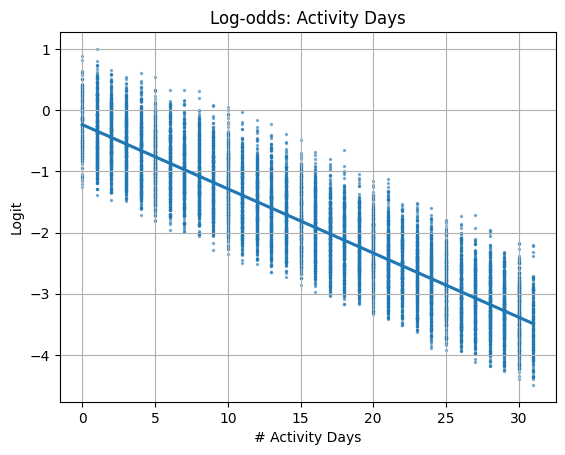

In [58]:
# crearing regplot for the log-odds of activity days
sns.regplot(x="activity_days", y="logit", data=logit_data, scatter_kws={"s": 2, "alpha": 0.5})
plt.title("Log-odds: Activity Days")
plt.xlabel("# Activity Days")
plt.ylabel("Logit")
plt.grid(zorder=0)
plt.show()

In [59]:
# getting predictions and score on testing set
y_preds = log_clf.predict(X_test)
log_clf.score(X_test, y_test)

0.8243356643356643

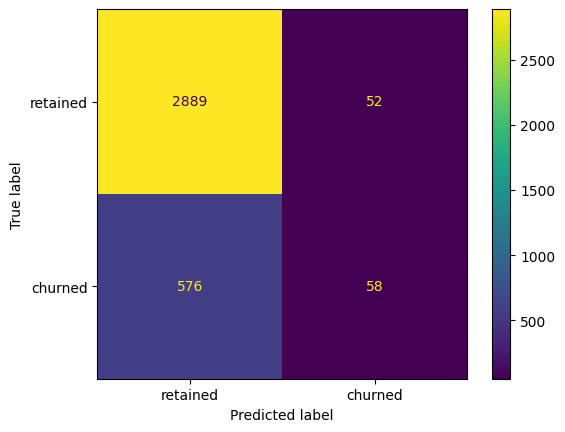

In [60]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_preds)

# creating confusion matrix visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["retained", "churned"])
disp.plot()
plt.show()

In [61]:
# calculating precision
print("Accuracy:", (cm[0,0] + cm[1,1]) / (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]))
print("Precision:", cm[1,1] / (cm[0,1] + cm[1,1]))
print("Recall:", cm[1,1] / (cm[1,0] + cm[1,1]))

Accuracy: 0.8243356643356643
Precision: 0.5272727272727272
Recall: 0.0914826498422713


In [62]:
# creating classification report for logistic regression model
target_labels = ["retained", "churned"]
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.53      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



In [63]:
# getting feature names and coefficients from the model
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Coefficient":log_clf.coef_[0]})

,Feature Name,Coefficient
0,drives,0.001947
1,total_sessions,0.000369
2,n_days_after_onboarding,-0.000400
3,total_navigations_fav1,0.001258
4,total_navigations_fav2,0.001007
5,driven_km_drives,-0.000012
6,duration_minutes_drives,0.000110
7,activity_days,-0.105097
8,km_per_driving_day,0.000020
9,professional_driver,-0.010719


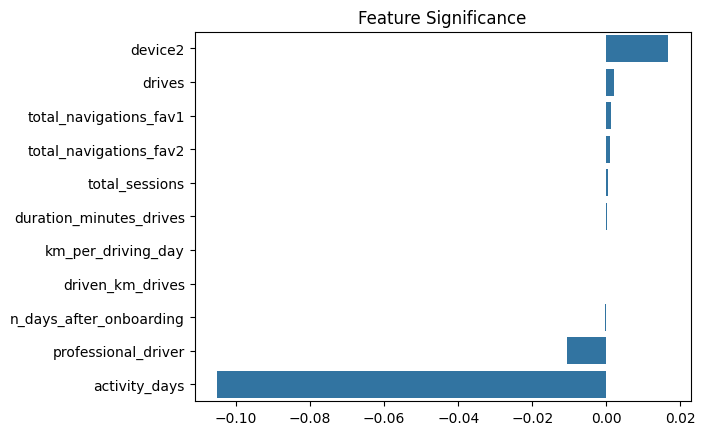

In [64]:
# creating list of tuples for the feature and its coefficient
feature_significance = list(zip(log_clf.feature_names_in_, log_clf.coef_[0]))
feature_significance = sorted(feature_significance, key=lambda x: x[1], reverse=True)

# plotting feature significance
sns.barplot(x=[x[1] for x in feature_significance],
            y=[x[0] for x in feature_significance],
            orient="h")
plt.title("Feature Significance")
plt.show()

The number of activity days emerged as the most significant predictor in the model, exhibiting a negative correlation with user churn. This was expected due to its strong relationship with the number of driving days, which was identified in the EDA as having a similar trend. Although the variable `km_per_driving_day` for the distance per driving day showed a strong positive correlation with churn during EDA, it had minimal impact in the final model. In logistic regression models, interactions between variables can sometimes result in unexpected outcomes. This can enhance a model's predictive accuracy but might obscure straightforward explanations. The model's utility depends on its intended use. It is not suitable for high-impact decisions due to its poor recall score but can guide further analysis. Improving the model could involve adding new features based on domain knowledge or testing different variable combinations to enhance performance.